In [38]:
%load_ext autoreload
%autoreload 2

#Science and Data
import pandas as pd
import numpy as np
import pymc3 as pm
from pymc3.ode import DifferentialEquation
from scipy.integrate import odeint

# Infrastructure
from pathlib import Path
import sys
import os

#Plotting Tools
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import theano

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Epidemiological Example

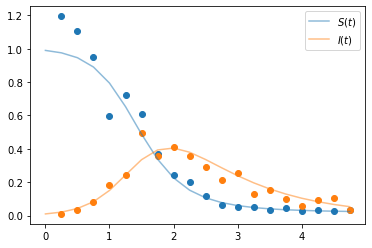

In [5]:
def SIR(y, t, p):
    ds = -p[0]*y[0]*y[1]
    di = p[0]*y[0]*y[1] - p[1]*y[1]
    return [ds, di]

times = np.arange(0,5,0.25)

beta,gamma = 4,1.0
# Create true curves
y = odeint(SIR, t=times, y0=[0.99, 0.01], args=((beta,gamma),), rtol=1e-8)
# Observational model.  Lognormal likelihood isn't appropriate, but we'll do it anyway
yobs = np.random.lognormal(mean=np.log(y[1::]), sigma=[0.2, 0.3])


plt.plot(times[1::],yobs, marker='o', linestyle='none')
plt.plot(times, y[:,0], color='C0', alpha=0.5, label=f'$S(t)$')
plt.plot(times, y[:,1], color ='C1', alpha=0.5, label=f'$I(t)$')
plt.legend()
plt.show()


In [7]:
sir_model = DifferentialEquation(
    func=SIR,
    times=np.arange(0.25, 5, 0.25),
    n_states=2,
    n_theta=2,
    t0=0,
)

with pm.Model() as model4:
    sigma = pm.HalfCauchy('sigma', 1, shape=2)

    # R0 is bounded below by 1 because we see an epidemic has occured
    R0 = pm.Bound(pm.Normal, lower=1)('R0', 2,3)
    lam = pm.Lognormal('lambda',pm.math.log(2),2)
    beta = pm.Deterministic('beta', lam*R0)

    sir_curves = sir_model(y0=[0.99, 0.01], theta=[beta, lam])

    Y = pm.Lognormal('Y', mu=pm.math.log(sir_curves), sd=sigma, observed=yobs)

    prior = pm.sample_prior_predictive()
    trace = pm.sample(2000, tune=1000, target_accept=0.9, cores=1)
    posterior_predictive = pm.sample_posterior_predictive(trace)

    data = az.from_pymc3(trace=trace, prior = prior, posterior_predictive = posterior_predictive)

AttributeError: 'Version' object has no attribute 'major'

# Competitive Model

## Simple Lotka-Volterra

src: https://scipy-cookbook.readthedocs.io/items/LoktaVolterraTutorial.html

In [43]:
import pylab as p
# Definition of parameters
a = 1.
b = 0.1
c = 1.5
d = 0.75
def f(x, t=0):
    """ Return the growth rate of fox and rabbit populations. """
    
    dx = a*x[0] -   b*x[0]*x[1]
    dy = -c*x[1] + d*b*x[0]*x[1]
    
    return np.array([dx, dy])


In [44]:
t = np.linspace(0, 15,  1000)              # time
x0 = np.array([10, 5])                     # initials conditions: 10 rabbits and 5 foxes
x, infodict = odeint(f, x0, t, full_output=True)
infodict['message']                     # >>> 'Integration successful.'

'Integration successful.'

Text(0.5, 1.0, 'Evolution of fox and rabbit populations')

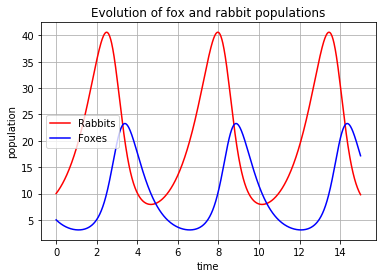

In [45]:
rabbits, foxes = x.T
f1 = p.figure()
p.plot(t, rabbits, 'r-', label='Rabbits')
p.plot(t, foxes  , 'b-', label='Foxes')
p.grid()
p.legend(loc='best')
p.xlabel('time')
p.ylabel('population')
p.title('Evolution of fox and rabbit populations')
# f1.savefig('rabbits_and_foxes_1.png')


## Competitive Lotka–Volterra equations

src:https://en.wikipedia.org/wiki/Competitive_Lotka%E2%80%93Volterra_equations

In [53]:
r1, r2, alpha12, alpha21 = 1, 0.72, 1.09, 0
K1, K2 = 1, 1
def f(x, t=0):
    
    dx = r1*x[0]*(1.0 - (x[0] + alpha12*x[1])/K1)
    dy = r2*x[1]*(1.0 - (x[1] + alpha21*x[0])/K2)
    
    return [dx, dy]

In [63]:
t = np.linspace(0, 15,  1000)
x0=np.array([10, 100])

# Create true curves
x, infodict = odeint(f, x0, t, full_output=True)

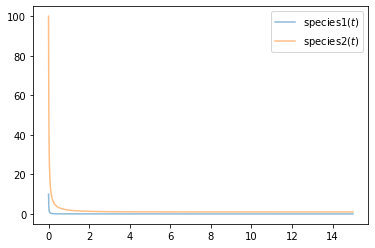

In [64]:
species1, species2 = x.T


plt.plot(t, species1, color='C0', alpha=0.5, label=f'species1$(t)$')
plt.plot(t, species2, color ='C1', alpha=0.5, label=f'species2$(t)$')
plt.legend()
plt.show()
